# Organizing data

In [0]:
!wget http://andrewjanowczyk.com/wp-static/mitosis.tgz

--2019-08-15 16:27:54--  http://andrewjanowczyk.com/wp-static/mitosis.tgz
Resolving andrewjanowczyk.com (andrewjanowczyk.com)... 129.22.136.73
Connecting to andrewjanowczyk.com (andrewjanowczyk.com)|129.22.136.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3523657634 (3.3G) [application/x-gzip]
Saving to: ‘mitosis.tgz’

mitosis.tgz         100%[===================>]   3.28G  2.25MB/s    in 14m 13s 

2019-08-15 16:42:07 (3.94 MB/s) - ‘mitosis.tgz’ saved [3523657634/3523657634]



In [0]:
mkdir mitosis

In [0]:
!tar -xvzf mitosis.tgz -C mitosis

In [0]:
mkdir data data/images data/br_masks

In [0]:
mkdir data/images/patches_i data/br_masks/patches_m

In [0]:
mv mitosis/*.tif data/images/

In [0]:
mv mitosis/*brmask.png data/br_masks/

# Patch extraction

In [0]:
# Credits: ICIAR2018 by ImagingLabs
class PatchExtractor:
    def __init__(self, img, patch_size, stride):
        '''
        :param img: :py:class:`~PIL.Image.Image`
        :param patch_size: integer, size of the patch
        :param stride: integer, size of the stride
        '''
        self.img = img
        self.size = patch_size
        self.stride = stride

    def extract_patches(self):
        """
        extracts all patches from an image
        :returns: A list of :py:class:`~PIL.Image.Image` objects.
        """
        wp, hp = self.shape()
        return [self.extract_patch((w, h)) for h in range(hp) for w in range(wp)]

    def extract_patch(self, patch):
        """
        extracts a patch from an input image
        :param patch: a tuple
        :rtype: :py:class:`~PIL.Image.Image`
        :returns: An :py:class:`~PIL.Image.Image` object.
        """
        return self.img.crop((
            patch[0] * self.stride,  # left
            patch[1] * self.stride,  # up
            patch[0] * self.stride + self.size,  # right
            patch[1] * self.stride + self.size  # down
        ))

    def shape(self):
        wp = int((self.img.width - self.size) / self.stride + 1)
        hp = int((self.img.height - self.size) / self.stride + 1)
        return wp, hp

In [0]:
import glob
from PIL import Image

PATCH_SIZE = 256

# This is the folder you'll find after extracting the dataset.
train_folder = './data/images'
labels = glob.glob(train_folder +  '/*.tif')
labels.sort()

In [0]:
for item in labels:
  try:
    with Image.open(item) as img:
      extractor = PatchExtractor(img=img, patch_size=PATCH_SIZE, stride=256)
      patches = extractor.extract_patches()
      count = 0
      for p in patches:
        count += 1
#         print('./data/images/patches_i/' + str(count) + '_' + item.split('/')[-1][:-3] + 'png')
        p.save('./data/images/patches_i/' + str(count) + '_' + item.split('/')[-1][:-3] + 'png')
  except Exception as error:
    print('error with', item, error)

In [0]:
labels = glob.glob('./data/br_masks/*.png')
labels.sort()

In [0]:
for item in labels:
  try:
    with Image.open(item) as img:
      extractor = PatchExtractor(img=img, patch_size=PATCH_SIZE, stride=256)
      patches = extractor.extract_patches()
      count = 0
      for p in patches:
        count += 1
        # print('./train/' + value + '/' + str(count) + '_' + key.split('/')[-1])
        p.save('./data/br_masks/patches_m/' + str(count) + '_' + item.split('/')[-1])
  except Exception as error:
    print('error with', item, error)

In [0]:
images = [item for item in glob.glob('data/images/patches_i/*')]

In [0]:
masks = [item for item in glob.glob('data/br_masks/patches_m/*')]

In [0]:
len(images), len(masks)

(15239, 15239)

In [0]:
images.sort()
masks.sort()

In [0]:
from PIL import Image
import numpy as np

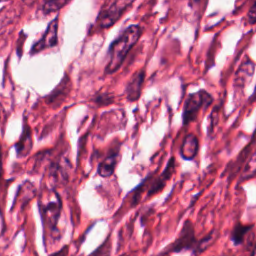

In [0]:
Image.open('data/images/patches_i/10_01_01.png')

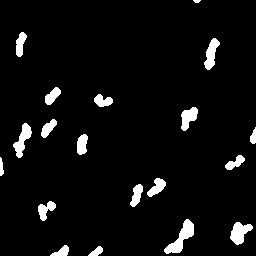

In [0]:
Image.open('data/br_masks/patches_m/10_01_01_brmask.png')

In [0]:
import sys
import os
from keras.utils import Progbar
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
# Function read train images and mask return as nump array
def read_train_data(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    X_train = np.zeros((len(images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(masks), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    if os.path.isfile("train_img.npy") and os.path.isfile("train_mask.npy"):
        print("Train file loaded from memory")
        X_train = np.load("train_img.npy")
        Y_train = np.load("train_mask.npy")
        return X_train,Y_train
    a = Progbar(len(images))
    for n, p in enumerate(zip(images, masks)):
        path = p[0]
        img = imread(path)[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        mask_ = imread(p[1])
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                    preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        Y_train[n] = mask
        a.update(n)
    np.save("train_img",X_train)
    np.save("train_mask",Y_train)
    return X_train,Y_train

Using TensorFlow backend.


In [0]:
train_img,train_mask = read_train_data()

Getting and resizing train images and masks ... 
15237/15239 [============================>.] - ETA: 0s

# Model Training

In [0]:
# Metric function
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Loss funtion
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [0]:
import os
import random
import sys
import warnings
import numpy as np
import pandas as pd
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.utils import Progbar

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

# Setting seed for reproducability
seed = 42
random.seed = seed
np.random.seed = seed
smooth = 1.
epochs = 50

In [0]:
def get_unet(IMG_WIDTH=256,IMG_HEIGHT=256,IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[dice_coef])
    return model

In [0]:
# get u_net model
u_net = get_unet()
u_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, 256, 256, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 256, 256, 16) 0           conv2d_78[0][0]                  
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, 256, 256, 16) 2320        dropout_37[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [0]:
# fit model on train_data
print("\nTraining...")
u_net.fit(train_img,train_mask,batch_size=96,epochs=15)

In [0]:
im = Image.open('data/images/patches_i/9_07_42.png')

In [0]:
px = np.array(im)/255
px = px.reshape((1,256,256,3))

In [0]:
e = u_net.predict(px).reshape((256,256))

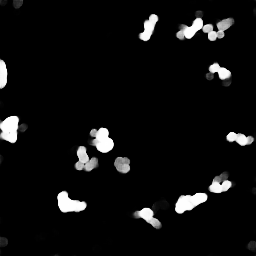

In [0]:
Image.fromarray((e*255).astype('uint8'))

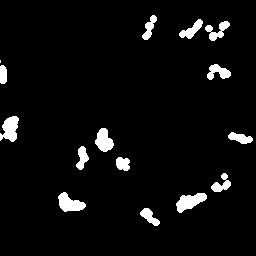

In [0]:
Image.open('data/br_masks/patches_m/9_07_42_brmask.png')

In [0]:
u_net.save('model.hdf5')

# Conversion

In [0]:
!pip install tensorflowjs

In [0]:
!tensorflowjs_converter --input_format=keras ./model.hdf5 ./tfjs_model